In [1]:
# Load libriaries.
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['lines.linewidth'] = 1.0
plt.rcParams['font.size'] = 6.0
plt.rcParams['axes.titlesize'] = 6.0

In [2]:
# Define base case.
W0 = [
    [-119, -14, -14],
    [-0.82, 0, 0],
    [0, 0.62, 0],
    [0, 0, 0.62],
    [0, 0, 0],
    [0, 0, 0] 
    ]
W0 = np.asarray(W0)

# Define stochastic gradient descent.
def stochastic_gradient_descent(sensors, references, W0=W0, pi=1e-1, h=25, gamma=1e-7):
    T = len(sensors)
    n_sensors = sensors.shape[1]
    n_references = references.shape[1]
    W = np.zeros((T, n_sensors + 1, n_references))
    W[0, ...] = W0
    E = np.diag([1, 10, 10])
    Y = np.zeros((T, n_references))
    for t in range(1, T):
        s = np.concatenate((np.ones(1), 
                            sensors.values[t]))[np.newaxis]
        r = references.values[t, np.newaxis]
        encounter = np.random.choice([True, False], 
                                     (1), 
                                     p=[pi, 1 - pi])
        if t <= h:
            encounter = True
        if encounter:
            g = np.dot(s.T, np.dot((np.dot(s,  W[(t - 1), ...]) - r), E))
            W[t, ...] = W[(t - 1), ...] - gamma * g
        else:
            W[t, ...] = W[(t - 1), ...]
        Y[t, ...] = np.dot(s, W[(t - 1), ...])
    return W, Y


# Define RMSProp.
def RMS_prop(sensors, references, W0=W0, pi=1e-1, h=25, gamma=1e-3, beta=0.99, eps=1e-8):
    T = len(sensors)
    n_sensors = sensors.shape[1]
    n_references = references.shape[1]
    W = np.zeros((T, n_sensors + 1, n_references))
    W[0, ...] = W0
    E = np.diag([1, 10, 10])
    r = np.zeros((n_sensors + 1, n_references))
    Y = np.zeros((T, n_references))
    for t in range(1, T):
        s = np.concatenate((np.ones(1), 
                            sensors.values[t]))[np.newaxis]
        r = references.values[t, np.newaxis]
        encounter = np.random.choice([True, False], 
                                     (1), 
                                     p=[pi, 1 - pi])
        if t <= h:
            encounter = True
        if encounter:
            g = np.dot(s.T, np.dot((np.dot(s,  W[(t - 1), ...]) - r), E))
            r = beta * r + (1 - beta) * np.multiply(g, g)
            v = - gamma * np.multiply(np.divide(1, np.sqrt(r + eps)), g)
            W[t, ...] = W[(t - 1), ...] + v
        else:
            W[t, ...] = W[(t - 1), ...]
        Y[t, ...] = np.dot(s, W[(t - 1), ...])
    return W, Y


# Define RMSProp with momentum.
def RMS_prop_momentum(sensors, references, W0=W0, pi=1e-1, h=25, gamma=1e-3, alpha=0.50, beta=0.99, eps=1e-8):
    T = len(sensors)
    n_sensors = sensors.shape[1]
    n_references = references.shape[1]
    W = np.zeros((T, n_sensors + 1, n_references))
    W[0, ...] = W0
    E = np.diag([1, 10, 10])
    r = np.zeros((n_sensors + 1, n_references))
    v = np.zeros((n_sensors + 1, n_references))
    Y = np.zeros((T, n_references))
    for t in range(1, T):
        s = np.concatenate((np.ones(1), 
                            sensors.values[t]))[np.newaxis]
        r = references.values[t, np.newaxis]
        encounter = np.random.choice([True, False], 
                                     (1), 
                                     p=[pi, 1 - pi])
        if t <= h:
            encounter = True
        if encounter:
            W_int = W[(t - 1), ...] + alpha * v
            g = np.dot(s.T, np.dot((np.dot(s,  W_int) - r), E))
            r = beta * r + (1 - beta) * np.multiply(g, g)
            v = alpha * v - gamma * np.multiply(np.divide(1, np.sqrt(r + eps)), g)
            W[t, ...] = W[(t - 1), ...] + v
        else:
            W[t, ...] = W[(t - 1), ...]
        Y[t, ...] = np.dot(s, W[(t - 1), ...])
    return W, Y


# Define moving-average function.
def moving_average(x, w=672, mode="same"):
    if mode == "same":
        return np.convolve(x, np.ones(w), mode) / w
    elif mode == "valid":
        z = np.concatenate((np.repeat(x[0], w/2), 
                            x, 
                            np.repeat(x[-1], (w - 1)/2)))
        return np.convolve(z, np.ones(w), mode) / w
    else:
        return np.convolve(x, np.ones(w), mode) / w
        

In [3]:
# Load data and keep only first six months.
data = pd.read_csv("Zimmerman2018.csv", index_col=0)

# Visualize data summary.
data.describe()

,CO_ref,CO2_ref,SO2_ref,NO2_ref,O3_ref,Alphasense_CO-B41#1,Alphasense_SO2-B4#1,Alphasense_NO2-B43F#1,Alphasense_OX-B431#1,CO2#1,...,CO2#18,T#18,RH#18,Alphasense_CO-B41#19,Alphasense_SO2-B4#19,Alphasense_NO2-B43F#19,Alphasense_OX-B431#19,CO2#19,T#19,RH#19
count,14630.000000,13830.000000,2234.000000,9429.000000,14194.000000,6574.000000,6574.000000,6574.000000,6574.000000,6574.000000,...,9219.000000,9219.000000,9219.000000,6570.000000,6570.000000,6570.000000,6570.000000,6570.000000,6570.000000,6570.000000
mean,263.118649,442.705800,1.031936,10.887076,22.100680,-185.588917,7.758719,12.703853,23.552130,769.501245,...,892.599772,16.693705,71.260951,-100.080652,6.142436,6.126899,26.699868,618.874086,21.112909,68.543435
std,237.577854,30.467453,1.143763,7.492827,11.515163,168.256504,7.201765,3.524194,5.830497,457.354590,...,590.472150,8.736281,12.981758,200.032452,8.352555,6.287330,11.482361,145.373696,7.863764,14.374059
min,39.511100,403.020000,0.001100,0.038420,0.004304,-1996.370000,-38.672700,1.650790,5.576270,1.555560,...,0.000000,-4.653330,31.868300,-2271.500000,-37.916700,-17.132100,-7.129030,0.163934,-7.710000,31.720300
25%,156.679750,425.462000,0.306059,5.604380,14.150550,-186.308500,4.387242,10.408000,19.485200,462.862250,...,529.192000,9.700000,61.719000,-159.358000,1.083685,2.656473,17.740875,532.911000,17.400000,57.164650
50%,190.287000,432.782500,0.673145,8.729700,21.301700,-124.200000,8.939960,12.527300,23.220200,615.553000,...,720.000000,17.300000,72.200000,-100.500000,5.474130,6.157890,25.008350,594.884000,22.236450,69.800000
75%,264.302500,447.236750,1.266405,13.683400,28.902025,-100.436000,12.290750,14.655575,27.230525,947.830750,...,1125.420000,23.409100,82.043750,-30.456950,10.283000,10.000000,34.106475,705.833500,26.210375,80.299525
max,3234.940000,672.386000,8.270540,44.994100,80.614900,-20.836400,23.961500,29.491500,51.000000,2001.000000,...,2001.000000,35.724600,94.850000,564.964000,34.000000,32.092600,74.000000,1447.500000,37.272200,96.200000


In [4]:
# Stratify data.
data_red = data[(data.index >= "2016-10-17 00:00:00")].dropna(axis=1, how="any", thresh=0.66*sum(data.index >= "2016-10-17 00:00:00"))
data_red.index = pd.to_datetime(data_red.index)
data_red_nan_indicator = data_red.notna()
data_red.fillna(method="ffill", axis=0, inplace=True)
# data_red = data_red.resample("1H").mean()
t_s = (data_red.index-data_red.index[0]).values.astype("timedelta64[h]") # time in minutes
data_red.head()

,CO_ref,CO2_ref,NO2_ref,O3_ref,Alphasense_CO-B41#4,Alphasense_SO2-B4#4,Alphasense_NO2-B43F#4,Alphasense_OX-B431#4,CO2#4,T#4,RH#4,Alphasense_CO-B41#16,Alphasense_SO2-B4#16,Alphasense_NO2-B43F#16,Alphasense_OX-B431#16,CO2#16,T#16,RH#16
timestamp,,,,,,,,,,,,,,,,,,
2016-10-17 00:00:00,573.289,435.040,15.17570,17.6092,-453.200,-1.98182,8.10909,19.6182,503.164,19.3000,71.1764,-410.682,2.409090,11.11360,22.0909,564.500,19.5000,66.7227
2016-10-17 00:15:00,482.237,434.877,12.69980,19.0694,-381.291,-2.54545,6.72727,15.4727,500.145,19.3000,71.0945,-336.432,0.772727,9.00000,18.4545,567.205,19.4659,66.6909
2016-10-17 00:30:00,403.774,432.974,10.62830,22.2521,-319.091,0.80000,6.96364,20.2909,502.073,19.2964,71.2400,-287.810,0.642857,7.33333,16.7619,553.786,19.4000,66.6167
2016-10-17 00:45:00,286.722,433.586,8.81866,22.3406,-246.429,1.30357,8.58929,21.5536,502.554,19.2000,71.7196,-203.875,3.650000,8.95000,21.8000,565.000,19.4000,66.6000
2016-10-17 01:00:00,259.170,433.165,8.56522,21.9404,-222.367,1.71667,9.88333,23.7000,503.100,18.9817,73.4167,-182.837,4.930230,11.46510,24.6977,559.163,19.3698,66.6000


# Device #4

In [5]:
# Select traces.
references_labels = ['CO_ref', 'NO2_ref', 'O3_ref']
sensors_1_labels = ['Alphasense_CO-B41#4', 'Alphasense_NO2-B43F#4', 'Alphasense_OX-B431#4', 'T#4', 'RH#4']

# Create training sets.
sensors_1 = data_red[sensors_1_labels]
references = data_red[references_labels]

# Create missing value indicator.
indicator_1 = data_red_nan_indicator[sensors_1_labels + references_labels]
ind_1 = indicator_1.all(axis=1).values

In [6]:
model = LinearRegression(fit_intercept=False)

T = sensors_1.values.shape[0]
S = np.concatenate((np.ones((T, 1)), sensors_1.values), axis=1)
R = references.values

W_best = model.fit(S, R).coef_

## Stochastic Gradient Descent

In [6]:
# Simulate.
W, Y = stochastic_gradient_descent(sensors_1, references, pi=1e-1)

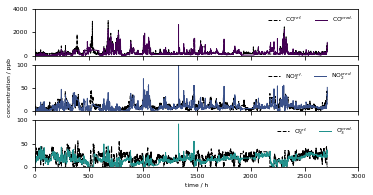

In [23]:
# Plot calibrated time traces.
figure, axes = plt.subplots(3, 1, sharex=True, figsize=(2*2.90, 1*2.90))

axes[0].plot(t_s, references["CO_ref"].values, "--", color="k", label="CO$^{ref.}$")
axes[0].plot(t_s, Y[:, 0], "-",  color=plt.cm.viridis(0), alpha=1.0, label="CO$^{pred.}$")
axes[0].legend(frameon=False, loc=1, ncol=2)
axes[0].set_xlim(0, 3e3)
axes[0].set_ylim(0, 4000)

axes[1].plot(t_s, references["NO2_ref"].values, "--", color="k", label="NO$_2^{ref.}$")
axes[1].plot(t_s, Y[:, 1], "-",  color=plt.cm.viridis(0.25), alpha=1.0, label="NO$_2^{pred.}$")
axes[1].legend(frameon=False, loc=1, ncol=2)
axes[1].set_ylim(0, 100)

axes[2].plot(t_s, references["O3_ref"].values, "--", color="k", label="O$_3^{ref.}$")
axes[2].plot(t_s, Y[:, 2], "-",  color=plt.cm.viridis(0.5), alpha=1.0, label="O$_3^{pred.}$")
axes[2].legend(frameon=False, loc=1, ncol=2)
axes[2].set_ylim(0, 100)

axes[1].set_ylabel("concentration / ppb")
axes[2].set_xlabel("time / h")
plt.savefig('./figures/device_1/SGD/calibrated_time_traces',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

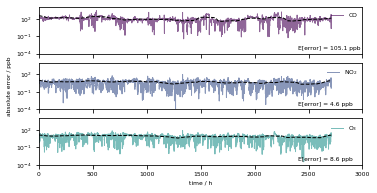

In [8]:
# Plot absolute errors.
figure, axes = plt.subplots(3, 1, sharex=True, figsize=(2*2.90, 1*2.90))

e = np.sqrt((Y[:, 0] - references["CO_ref"].values)**2)
axes[0].plot(t_s, e, "-",  color=plt.cm.viridis(0), alpha=0.6, label="CO")
axes[0].plot(t_s, moving_average(e, mode="valid"), "--",  color="k")
axes[0].text(2400, 4e-4, "E[error] = "+str(np.round(np.mean(e), 1))+" ppb")
axes[0].legend(frameon=False, loc=1)
axes[0].set_xlim(0, 3e3)
axes[0].set_yscale("log")
axes[0].set_ylim(1e-4, 1e4)

e = np.sqrt((Y[:, 1] - references["NO2_ref"].values)**2)
axes[1].plot(t_s, e, "-",  color=plt.cm.viridis(0.25), alpha=0.6, label="NO$_2$")
axes[1].plot(t_s, moving_average(e, mode="valid"), "--",  color="k")
axes[1].text(2400, 4e-4, "E[error] = "+str(np.round(np.mean(e), 1))+" ppb")
axes[1].legend(frameon=False, loc=1)
axes[1].set_yscale("log")
axes[1].set_ylim(1e-4, 1e4)

e = np.sqrt((Y[:, 2] - references["O3_ref"].values)**2)
axes[2].plot(t_s, e, "-",  color=plt.cm.viridis(0.5), alpha=0.6, label="O$_3$")
axes[2].plot(t_s, moving_average(e, mode="valid"), "--",  color="k")
axes[2].text(2400, 4e-4, "E[error] = "+str(np.round(np.mean(e), 1))+" ppb")
axes[2].legend(frameon=False, loc=1)
axes[2].set_yscale("log")
axes[2].set_ylim(1e-4, 1e4)

axes[1].set_ylabel("absolute error / ppb")
axes[2].set_xlabel("time / h")
plt.savefig('./figures/device_1/SGD/calibrated_time_traces_error',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

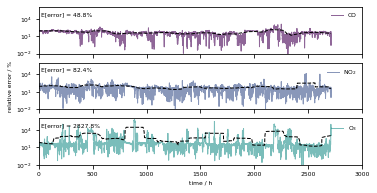

In [9]:
# Plot relative error.
figure, axes = plt.subplots(3, 1, sharex=True, figsize=(2*2.90, 1*2.90))

e = 100*np.sqrt((Y[:, 0] - references["CO_ref"].values)**2)/references["CO_ref"].values
axes[0].plot(t_s, e, "-",  color=plt.cm.viridis(0), alpha=0.6, label="CO")
axes[0].plot(t_s, moving_average(e, mode="valid"), "--",  color="k")
axes[0].text(25, 2.9e4, "E[error] = "+str(np.round(np.mean(e), 1))+"%")
axes[0].legend(frameon=False, loc=1)
axes[0].set_xlim(0, 3e3)
axes[0].set_yscale("log")
axes[0].set_ylim(1e-2, 1e6)

e = 100*np.sqrt((Y[:, 1] - references["NO2_ref"].values)**2)/references["NO2_ref"].values
axes[1].plot(t_s, e, "-",  color=plt.cm.viridis(0.25), alpha=0.6, label="NO$_2$")
axes[1].plot(t_s, moving_average(e, mode="valid"), "--",  color="k")
axes[1].text(25, 2.9e4, "E[error] = "+str(np.round(np.mean(e), 1))+"%")
axes[1].legend(frameon=False, loc=1)
axes[1].set_yscale("log")
axes[1].set_ylim(1e-2, 1e6)

e = 100*np.sqrt((Y[:, 2] - references["O3_ref"].values)**2)/references["O3_ref"].values
axes[2].plot(t_s, e, "-",  color=plt.cm.viridis(0.5), alpha=0.6, label="O$_3$")
axes[2].plot(t_s, moving_average(e, mode="valid"), "--",  color="k")
axes[2].text(25, 2.9e4, "E[error] = "+str(np.round(np.mean(e), 1))+"%")
axes[2].legend(frameon=False, loc=1)
axes[2].set_yscale("log")
axes[2].set_ylim(1e-2, 1e6)

axes[1].set_ylabel("relative error / %")
axes[2].set_xlabel("time / h")
plt.savefig('./figures/device_1/SGD/calibrated_time_traces_rel_error',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

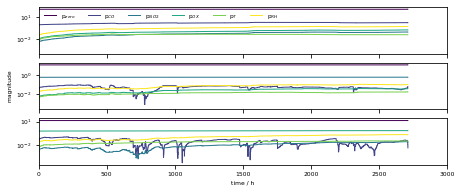

In [7]:
# Plot parameters.
figure, axes = plt.subplots(3, 1, sharex=True, figsize=(2.525*2.90, 1*2.90))
labels = ["zero", "CO", "NO2", "OX", "T", "RH"]
n_parameters = len(sensors_1_labels)+1

for k in range(n_parameters):
    axes[0].plot(t_s, np.abs(W[:, k, 0]),  color=plt.cm.viridis(k / (n_parameters-1)), label="p$_{"+labels[k]+"}$")
# axes[0].text(2875, -5.6, "CO")
axes[0].legend(frameon=False, loc=2, ncol=6)
axes[0].set_xlim(0, 3e3)
axes[0].set_yscale("log")
#axes[0].set_ylim(-6, 6)
#axes[0].set_yticks(np.linspace(-6, 24, 4))

for k in range(n_parameters):
    axes[1].plot(t_s, np.abs(W[:, k, 1]),  color=plt.cm.viridis(k / (n_parameters-1)), label="p$_{"+labels[k]+"}$")
# axes[1].text(2875, -1.8, "NO$_2$")
# axes[1].legend(frameon=False, loc=2, ncol=6)
axes[1].set_yscale("log")
#axes[1].set_ylim(-2, 2)
#axes[1].set_yticks(np.linspace(-2, 2, 5))

for k in range(n_parameters):
    axes[2].plot(t_s, np.abs(W[:, k, 2]),  color=plt.cm.viridis(k / (n_parameters-1)), label="p$_{"+labels[k]+"}$")
# axes[2].text(2875, -1.8, "O$_3$")
# axes[2].legend(frameon=False, loc=2, ncol=6)
axes[2].set_yscale("log")
#axes[2].set_ylim(-2, 2)
#axes[2].set_yticks(np.linspace(-2, 2, 5))

axes[1].set_ylabel("magnitude")
axes[2].set_xlabel("time / h")
plt.savefig('./figures/device_1/SGD/parameters',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

## RMSProp

In [6]:
W, Y = RMS_prop(sensors_1, references, pi=1e-1)

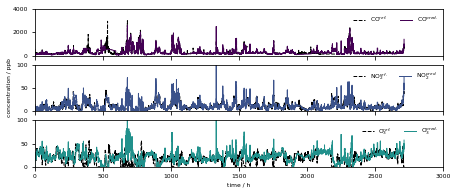

In [9]:
# Plot calibrated time traces.
figure, axes = plt.subplots(3, 1, sharex=True, figsize=(2.525*2.90, 1*2.90))

axes[0].plot(t_s, references["CO_ref"].values, "--", color="k", label="CO$^{ref.}$")
axes[0].plot(t_s, Y[:, 0], "-",  color=plt.cm.viridis(0), alpha=1.0, label="CO$^{pred.}$")
axes[0].legend(frameon=False, loc=1, ncol=2)
axes[0].set_xlim(0, 3e3)
axes[0].set_ylim(0, 4000)

axes[1].plot(t_s, references["NO2_ref"].values, "--", color="k", label="NO$_2^{ref.}$")
axes[1].plot(t_s, Y[:, 1], "-",  color=plt.cm.viridis(0.25), alpha=1.0, label="NO$_2^{pred.}$")
axes[1].legend(frameon=False, loc=1, ncol=2)
axes[1].set_ylim(0, 100)

axes[2].plot(t_s, references["O3_ref"].values, "--", color="k", label="O$_3^{ref.}$")
axes[2].plot(t_s, Y[:, 2], "-",  color=plt.cm.viridis(0.5), alpha=1.0, label="O$_3^{pred.}$")
axes[2].legend(frameon=False, loc=1, ncol=2)
axes[2].set_ylim(0, 100)

axes[1].set_ylabel("concentration / ppb")
axes[2].set_xlabel("time / h")
plt.savefig('./figures/device_1/RMS_prop/calibrated_time_traces',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

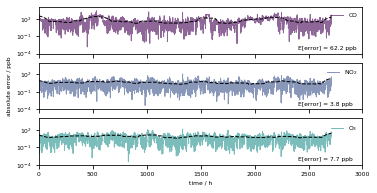

In [13]:
# Plot absolute errors.
figure, axes = plt.subplots(3, 1, sharex=True, figsize=(2*2.90, 1*2.90))

e = np.sqrt((Y[:, 0] - references["CO_ref"].values)**2)
axes[0].plot(t_s, e, "-",  color=plt.cm.viridis(0), alpha=0.6, label="CO")
axes[0].plot(t_s, moving_average(e, mode="valid"), "--",  color="k")
axes[0].text(2400, 4e-4, "E[error] = "+str(np.round(np.mean(e), 1))+" ppb")
axes[0].legend(frameon=False, loc=1)
axes[0].set_xlim(0, 3e3)
axes[0].set_yscale("log")
axes[0].set_ylim(1e-4, 1e4)

e = np.sqrt((Y[:, 1] - references["NO2_ref"].values)**2)
axes[1].plot(t_s, e, "-",  color=plt.cm.viridis(0.25), alpha=0.6, label="NO$_2$")
axes[1].plot(t_s, moving_average(e, mode="valid"), "--",  color="k")
axes[1].text(2400, 4e-4, "E[error] = "+str(np.round(np.mean(e), 1))+" ppb")
axes[1].legend(frameon=False, loc=1)
axes[1].set_yscale("log")
axes[1].set_ylim(1e-4, 1e4)

e = np.sqrt((Y[:, 2] - references["O3_ref"].values)**2)
axes[2].plot(t_s, e, "-",  color=plt.cm.viridis(0.5), alpha=0.6, label="O$_3$")
axes[2].plot(t_s, moving_average(e, mode="valid"), "--",  color="k")
axes[2].text(2400, 4e-4, "E[error] = "+str(np.round(np.mean(e), 1))+" ppb")
axes[2].legend(frameon=False, loc=1)
axes[2].set_yscale("log")
axes[2].set_ylim(1e-4, 1e4)

axes[1].set_ylabel("absolute error / ppb")
axes[2].set_xlabel("time / h")
plt.savefig('./figures/device_1/RMS_prop/calibrated_time_traces_error',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

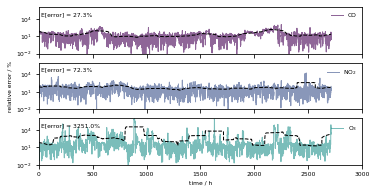

In [14]:
# Plot relative error.
figure, axes = plt.subplots(3, 1, sharex=True, figsize=(2*2.90, 1*2.90))

e = 100*np.sqrt((Y[:, 0] - references["CO_ref"].values)**2)/references["CO_ref"].values
axes[0].plot(t_s, e, "-",  color=plt.cm.viridis(0), alpha=0.6, label="CO")
axes[0].plot(t_s, moving_average(e, mode="valid"), "--",  color="k")
axes[0].text(25, 2.9e4, "E[error] = "+str(np.round(np.mean(e), 1))+"%")
axes[0].legend(frameon=False, loc=1)
axes[0].set_xlim(0, 3e3)
axes[0].set_yscale("log")
axes[0].set_ylim(1e-2, 1e6)

e = 100*np.sqrt((Y[:, 1] - references["NO2_ref"].values)**2)/references["NO2_ref"].values
axes[1].plot(t_s, e, "-",  color=plt.cm.viridis(0.25), alpha=0.6, label="NO$_2$")
axes[1].plot(t_s, moving_average(e, mode="valid"), "--",  color="k")
axes[1].text(25, 2.9e4, "E[error] = "+str(np.round(np.mean(e), 1))+"%")
axes[1].legend(frameon=False, loc=1)
axes[1].set_yscale("log")
axes[1].set_ylim(1e-2, 1e6)

e = 100*np.sqrt((Y[:, 2] - references["O3_ref"].values)**2)/references["O3_ref"].values
axes[2].plot(t_s, e, "-",  color=plt.cm.viridis(0.5), alpha=0.6, label="O$_3$")
axes[2].plot(t_s, moving_average(e, mode="valid"), "--",  color="k")
axes[2].text(25, 2.9e4, "E[error] = "+str(np.round(np.mean(e), 1))+"%")
axes[2].legend(frameon=False, loc=1)
axes[2].set_yscale("log")
axes[2].set_ylim(1e-2, 1e6)

axes[1].set_ylabel("relative error / %")
axes[2].set_xlabel("time / h")
plt.savefig('./figures/device_1/RMS_prop/calibrated_time_traces_rel_error',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

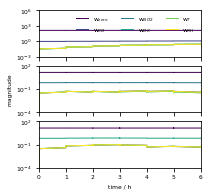

In [18]:
# Plot parameters.
figure, axes = plt.subplots(3, 1, sharex=True, figsize=(1*2.90, 1*2.90))
labels = ["zero", "CO", "NO2", "OX", "T", "RH"]
linestyles = ["-", "-", "-"]*2
n_parameters = len(sensors_1_labels)+1

for k in range(n_parameters):
    axes[0].plot(t_s, np.abs(W[:, k, 0]),  linestyle=linestyles[k], color=plt.cm.viridis(k / (n_parameters-1)), label="w$_{"+labels[k]+"}$")
# axes[0].text(2875, 0.01, "CO")
axes[0].legend(frameon=False, loc=0, ncol=3)
axes[0].set_xlim(0, 6)
axes[0].set_yscale("log")
axes[0].set_ylim(1e-3, 1e6)
#axes[0].set_ylim(-4, 4)
#axes[0].set_yticks(np.linspace(-4, 4, 5))

for k in range(n_parameters):
    axes[1].plot(t_s, np.abs(W[:, k, 1]),  linestyle=linestyles[k], color=plt.cm.viridis(k / (n_parameters-1)), label="w$_{"+labels[k]+"}$")
#axes[1].text(2875, -0.85, "NO$_2$")
# axes[1].legend(frameon=False, loc=2, ncol=6)
axes[1].set_yscale("log")
axes[1].set_ylim(1e-4, 1e2)
#axes[1].set_ylim(-1, 1)
#axes[1].set_yticks(np.linspace(-1, 1, 5))

for k in range(n_parameters):
    axes[2].plot(t_s, np.abs(W[:, k, 2]),  linestyle=linestyles[k], color=plt.cm.viridis(k / (n_parameters-1)), label="w$_{"+labels[k]+"}$")
#axes[2].text(2875, -1.75, "O$_3$")
# axes[2].legend(frameon=False, loc=2, ncol=6)
axes[2].set_yscale("log")
axes[2].set_ylim(1e-4, 1e2)
#axes[2].set_ylim(-2, 2)
#axes[2].set_yticks(np.linspace(-2, 2, 5))

axes[1].set_ylabel("magnitude")
axes[2].set_xlabel("time / h")
plt.savefig('./figures/device_1/RMS_prop/parameters_short',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

## RMSProp with momentum

In [16]:
W, Y = RMS_prop_momentum(sensors_1, references, pi=1e-1)

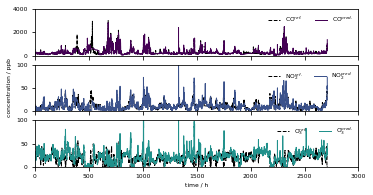

In [17]:
# Plot calibrated time traces.
figure, axes = plt.subplots(3, 1, sharex=True, figsize=(2*2.90, 1*2.90))

axes[0].plot(t_s, references["CO_ref"].values, "--", color="k", label="CO$^{ref.}$")
axes[0].plot(t_s, Y[:, 0], "-",  color=plt.cm.viridis(0), alpha=1.0, label="CO$^{pred.}$")
axes[0].legend(frameon=False, loc=1, ncol=2)
axes[0].set_xlim(0, 3e3)
axes[0].set_ylim(0, 4000)

axes[1].plot(t_s, references["NO2_ref"].values, "--", color="k", label="NO$_2^{ref.}$")
axes[1].plot(t_s, Y[:, 1], "-",  color=plt.cm.viridis(0.25), alpha=1.0, label="NO$_2^{pred.}$")
axes[1].legend(frameon=False, loc=1, ncol=2)
axes[1].set_ylim(0, 100)

axes[2].plot(t_s, references["O3_ref"].values, "--", color="k", label="O$_3^{ref.}$")
axes[2].plot(t_s, Y[:, 2], "-",  color=plt.cm.viridis(0.5), alpha=1.0, label="O$_3^{pred.}$")
axes[2].legend(frameon=False, loc=1, ncol=2)
axes[2].set_ylim(0, 100)

axes[1].set_ylabel("concentration / ppb")
axes[2].set_xlabel("time / h")
plt.savefig('./figures/device_1/RMS_prop_momentum/calibrated_time_traces',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

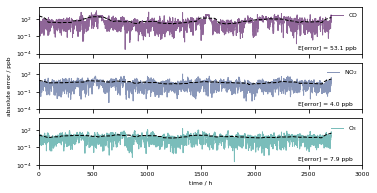

In [18]:
# Plot absolute errors.
figure, axes = plt.subplots(3, 1, sharex=True, figsize=(2*2.90, 1*2.90))

e = np.sqrt((Y[:, 0] - references["CO_ref"].values)**2)
axes[0].plot(t_s, e, "-",  color=plt.cm.viridis(0), alpha=0.6, label="CO")
axes[0].plot(t_s, moving_average(e, mode="valid"), "--",  color="k")
axes[0].text(2400, 4e-4, "E[error] = "+str(np.round(np.mean(e), 1))+" ppb")
axes[0].legend(frameon=False, loc=1)
axes[0].set_xlim(0, 3e3)
axes[0].set_yscale("log")
axes[0].set_ylim(1e-4, 1e4)

e = np.sqrt((Y[:, 1] - references["NO2_ref"].values)**2)
axes[1].plot(t_s, e, "-",  color=plt.cm.viridis(0.25), alpha=0.6, label="NO$_2$")
axes[1].plot(t_s, moving_average(e, mode="valid"), "--",  color="k")
axes[1].text(2400, 4e-4, "E[error] = "+str(np.round(np.mean(e), 1))+" ppb")
axes[1].legend(frameon=False, loc=1)
axes[1].set_yscale("log")
axes[1].set_ylim(1e-4, 1e4)

e = np.sqrt((Y[:, 2] - references["O3_ref"].values)**2)
axes[2].plot(t_s, e, "-",  color=plt.cm.viridis(0.5), alpha=0.6, label="O$_3$")
axes[2].plot(t_s, moving_average(e, mode="valid"), "--",  color="k")
axes[2].text(2400, 4e-4, "E[error] = "+str(np.round(np.mean(e), 1))+" ppb")
axes[2].legend(frameon=False, loc=1)
axes[2].set_yscale("log")
axes[2].set_ylim(1e-4, 1e4)

axes[1].set_ylabel("absolute error / ppb")
axes[2].set_xlabel("time / h")
plt.savefig('./figures/device_1/RMS_prop_momentum/calibrated_time_traces_error',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

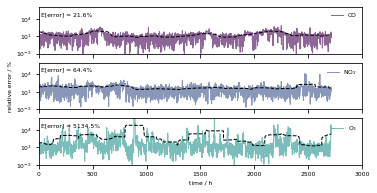

In [19]:
# Plot relative error.
figure, axes = plt.subplots(3, 1, sharex=True, figsize=(2*2.90, 1*2.90))

e = 100*np.sqrt((Y[:, 0] - references["CO_ref"].values)**2)/references["CO_ref"].values
axes[0].plot(t_s, e, "-",  color=plt.cm.viridis(0), alpha=0.6, label="CO")
axes[0].plot(t_s, moving_average(e, mode="valid"), "--",  color="k")
axes[0].text(25, 2.9e4, "E[error] = "+str(np.round(np.mean(e), 1))+"%")
axes[0].legend(frameon=False, loc=1)
axes[0].set_xlim(0, 3e3)
axes[0].set_yscale("log")
axes[0].set_ylim(1e-2, 1e6)

e = 100*np.sqrt((Y[:, 1] - references["NO2_ref"].values)**2)/references["NO2_ref"].values
axes[1].plot(t_s, e, "-",  color=plt.cm.viridis(0.25), alpha=0.6, label="NO$_2$")
axes[1].plot(t_s, moving_average(e, mode="valid"), "--",  color="k")
axes[1].text(25, 2.9e4, "E[error] = "+str(np.round(np.mean(e), 1))+"%")
axes[1].legend(frameon=False, loc=1)
axes[1].set_yscale("log")
axes[1].set_ylim(1e-2, 1e6)

e = 100*np.sqrt((Y[:, 2] - references["O3_ref"].values)**2)/references["O3_ref"].values
axes[2].plot(t_s, e, "-",  color=plt.cm.viridis(0.5), alpha=0.6, label="O$_3$")
axes[2].plot(t_s, moving_average(e, mode="valid"), "--",  color="k")
axes[2].text(25, 2.9e4, "E[error] = "+str(np.round(np.mean(e), 1))+"%")
axes[2].legend(frameon=False, loc=1)
axes[2].set_yscale("log")
axes[2].set_ylim(1e-2, 1e6)

axes[1].set_ylabel("relative error / %")
axes[2].set_xlabel("time / h")
plt.savefig('./figures/device_1/RMS_prop_momentum/calibrated_time_traces_rel_error',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

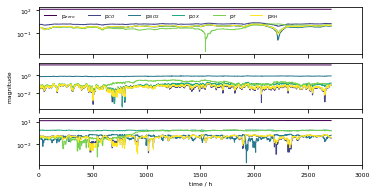

In [20]:
# Plot parameters.
figure, axes = plt.subplots(3, 1, sharex=True, figsize=(2*2.90, 1*2.90))
labels = ["zero", "CO", "NO2", "OX", "T", "RH"]
n_parameters = len(sensors_1_labels)+1

for k in range(n_parameters):
    axes[0].plot(t_s, np.abs(W[:, k, 0]),  color=plt.cm.viridis(k / (n_parameters-1)), label="p$_{"+labels[k]+"}$")
# axes[0].text(2875, -3.5, "CO")
axes[0].legend(frameon=False, loc=2, ncol=6)
axes[0].set_xlim(0, 3e3)
axes[0].set_yscale("log")
# axes[0].set_ylim(-4, 4)
# axes[0].set_yticks(np.linspace(-4, 4, 5))

for k in range(n_parameters):
    axes[1].plot(t_s, np.abs(W[:, k, 1]),  color=plt.cm.viridis(k / (n_parameters-1)), label="p$_{"+labels[k]+"}$")
# axes[1].text(2875, -0.85, "NO$_2$")
# axes[1].legend(frameon=False, loc=2, ncol=6)
axes[1].set_yscale("log")
# axes[1].set_ylim(-1, 1)
# axes[1].set_yticks(np.linspace(-1, 1, 5))

for k in range(n_parameters):
    axes[2].plot(t_s, np.abs(W[:, k, 2]),  color=plt.cm.viridis(k / (n_parameters-1)), label="p$_{"+labels[k]+"}$")
# axes[2].text(2875, -1.75, "O$_3$")
# axes[2].legend(frameon=False, loc=2, ncol=6)
axes[2].set_yscale("log")
# axes[2].set_ylim(-2, 2)
# axes[2].set_yticks(np.linspace(-2, 2, 5))

axes[1].set_ylabel("magnitude")
axes[2].set_xlabel("time / h")
plt.savefig('./figures/device_1/RMS_prop_momentum/parameters',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

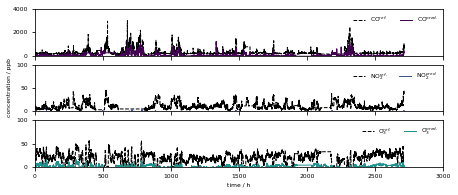

In [6]:
# Compute base case.
T = sensors_1.values.shape[0]
S = np.concatenate((np.ones((T, 1)), sensors_1.values), axis=1)
Y_base = np.dot(S, W0)

# Plot calibrated time traces.
figure, axes = plt.subplots(3, 1, sharex=True, figsize=(2.525*2.90, 1*2.90))

axes[0].plot(t_s, references["CO_ref"].values, "--", color="k", label="CO$^{ref.}$")
axes[0].plot(t_s, Y_base[:, 0], "-",  color=plt.cm.viridis(0), alpha=1.0, label="CO$^{pred.}$")
axes[0].legend(frameon=False, loc=1, ncol=2)
axes[0].set_xlim(0, 3e3)
axes[0].set_ylim(0, 4000)

axes[1].plot(t_s, references["NO2_ref"].values, "--", color="k", label="NO$_2^{ref.}$")
axes[1].plot(t_s, Y_base[:, 1], "-",  color=plt.cm.viridis(0.25), alpha=1.0, label="NO$_2^{pred.}$")
axes[1].legend(frameon=False, loc=1, ncol=2)
axes[1].set_ylim(0, 100)

axes[2].plot(t_s, references["O3_ref"].values, "--", color="k", label="O$_3^{ref.}$")
axes[2].plot(t_s, Y_base[:, 2], "-",  color=plt.cm.viridis(0.5), alpha=1.0, label="O$_3^{pred.}$")
axes[2].legend(frameon=False, loc=1, ncol=2)
axes[2].set_ylim(0, 100)

axes[1].set_ylabel("concentration / ppb")
axes[2].set_xlabel("time / h")
plt.savefig('./figures/device_1/base_case',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

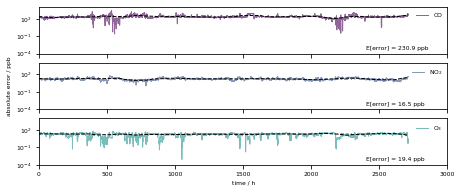

In [7]:
# Plot absolute errors of base case.
figure, axes = plt.subplots(3, 1, sharex=True, figsize=(2.525*2.90, 1*2.90))

e = np.sqrt((Y_base[:, 0] - references["CO_ref"].values)**2)
axes[0].plot(t_s, e, "-",  color=plt.cm.viridis(0), alpha=0.6, label="CO")
axes[0].plot(t_s, moving_average(e, mode="valid"), "--",  color="k")
axes[0].text(2400, 4e-4, "E[error] = "+str(np.round(np.mean(e), 1))+" ppb")
axes[0].legend(frameon=False, loc=1)
axes[0].set_xlim(0, 3e3)
axes[0].set_yscale("log")
axes[0].set_ylim(1e-4, 1e4)

e = np.sqrt((Y_base[:, 1] - references["NO2_ref"].values)**2)
axes[1].plot(t_s, e, "-",  color=plt.cm.viridis(0.25), alpha=0.6, label="NO$_2$")
axes[1].plot(t_s, moving_average(e, mode="valid"), "--",  color="k")
axes[1].text(2400, 4e-4, "E[error] = "+str(np.round(np.mean(e), 1))+" ppb")
axes[1].legend(frameon=False, loc=1)
axes[1].set_yscale("log")
axes[1].set_ylim(1e-4, 1e4)

e = np.sqrt((Y_base[:, 2] - references["O3_ref"].values)**2)
axes[2].plot(t_s, e, "-",  color=plt.cm.viridis(0.5), alpha=0.6, label="O$_3$")
axes[2].plot(t_s, moving_average(e, mode="valid"), "--",  color="k")
axes[2].text(2400, 4e-4, "E[error] = "+str(np.round(np.mean(e), 1))+" ppb")
axes[2].legend(frameon=False, loc=1)
axes[2].set_yscale("log")
axes[2].set_ylim(1e-4, 1e4)

axes[1].set_ylabel("absolute error / ppb")
axes[2].set_xlabel("time / h")
plt.savefig('./figures/device_1/base_case_time_traces_error',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

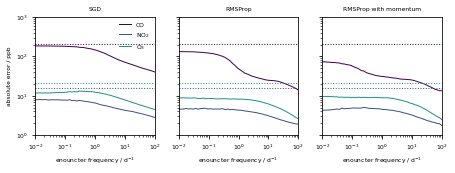

In [27]:
# Plot absolute errors of base case.
titles = ["SGD", "RMSProp", "RMSProp with momentum"]
figure, axes = plt.subplots(1, 3, sharey=True, figsize=(3.35*0.75*2.90, 0.75*2.90))

for m in range(3):
    ax = axes[m]
    n_runs = 50
    n_repeats = 100
    n_references = len(references_labels)
    pis = np.logspace(-4, 0, n_runs)
    errors = np.zeros((n_runs, n_repeats, n_references))
    for k, pi in enumerate(pis):
        for n in range(n_repeats):
            if m == 0:
                _, Y = stochastic_gradient_descent(sensors_1, references, pi=pi)
            elif m == 1:
                _, Y = RMS_prop(sensors_1, references, pi=pi)
            else:
                _, Y = RMS_prop_momentum(sensors_1, references, pi=pi)
            errors[k, n, 0] = np.mean(np.sqrt((Y[ind_1, 0] - references["CO_ref"].values[ind_1])**2))
            errors[k, n, 1] = np.mean(np.sqrt((Y[ind_1, 1] - references["NO2_ref"].values[ind_1])**2))
            errors[k, n, 2] = np.mean(np.sqrt((Y[ind_1, 2] - references["O3_ref"].values[ind_1])**2))
    np.save("lab_"+titles[m], errors)
    f = 100

    T = sensors_1.values.shape[0]
    S = np.concatenate((np.ones((T, 1)), sensors_1.values), axis=1)
    Y_base = np.dot(S, W0)
    base_case_error = np.mean(np.sqrt((Y_base[ind_1, :] - references.values[ind_1, :])**2), axis=0)

    ax.set_title(titles[m])
    ax.plot(pis*f, np.mean(errors[:, :, 0], axis=1), color=plt.cm.viridis(0), alpha=1.0, label="CO")
    ax.plot([pis[0]*f, pis[-1]*f], [base_case_error[0], base_case_error[0]], ":", color=plt.cm.viridis(0))
    ax.plot(pis*f, np.mean(errors[:, :, 1], axis=1), color=plt.cm.viridis(0.25), alpha=1.0, label="NO$_2$")
    ax.plot([pis[0]*f, pis[-1]*f], [base_case_error[1], base_case_error[1]], ":", color=plt.cm.viridis(0.25))
    ax.plot(pis*f, np.mean(errors[:, :, 2], axis=1), color=plt.cm.viridis(0.50), alpha=1.0, label="O$_3$")
    ax.plot([pis[0]*f, pis[-1]*f], [base_case_error[2], base_case_error[2]], ":", color=plt.cm.viridis(0.50))
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(1e-2, f)
    # axes.set_xticks(np.linspace(0, f, 5))
    ax.set_ylim(1e0, 1e3)
    # axes.set_yticks(np.linspace(0, 1000, 5))
    ax.set_xlabel("enouncter frequency / d$^{-1}$")
    axes[0].set_ylabel("absolute error / ppb")
    axes[0].legend(frameon=False)

plt.savefig('./figures/device_1/encounter_frequencies',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

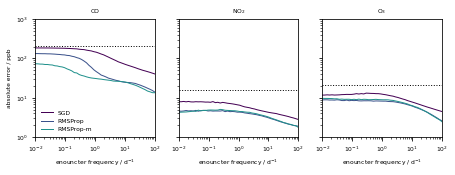

In [28]:
T = sensors_1.values.shape[0]
S = np.concatenate((np.ones((T, 1)), sensors_1.values), axis=1)
Y_base = np.dot(S, W0)
base_case_error = np.mean(np.sqrt((Y_base[ind_1, :] - references.values[ind_1, :])**2), axis=0)

err1 = np.load("lab_SGD.npy")
err2 = np.load("lab_RMSProp.npy")
err3 = np.load("lab_RMSProp with momentum.npy")
titles = ["CO", "NO$_2$", "O$_3$"]
figure, axes = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(3.35*0.75*2.90, 0.75*2.90))
for m in range(3):
    axes[m].set_title(titles[m])
    axes[m].plot(pis*f, np.mean(err1[:, :, m], axis=1), color=plt.cm.viridis(0), alpha=1.0, label="SGD")
    axes[m].plot(pis*f, np.mean(err2[:, :, m], axis=1), color=plt.cm.viridis(0.25), alpha=1.0, label="RMSProp")
    axes[m].plot(pis*f, np.mean(err3[:, :, m], axis=1), color=plt.cm.viridis(0.5), alpha=1.0, label="RMSProp-m")
    axes[m].plot([pis[0]*f, pis[-1]*f], [base_case_error[m], base_case_error[m]], ":", color="k")
    axes[m].set_xlabel("enouncter frequency / d$^{-1}$")
axes[0].set_xlim(1e-2, 1e2)
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_ylim(1e0, 1e3)
axes[0].legend(frameon=False, ncol=1, loc=0)
axes[0].set_ylabel("absolute error / ppb")
plt.savefig('./figures/device_1/encounter_frequencies',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()